### Biosynthetic Gene Clusters (BGCs) design using conditional Variational Autoencoder (cVAE)

The model is conditioned on the class of the BGC to which the protein or domain belongs (e.g., Class 1, Class 2).

In [1]:
#Loading packages
#Importing packages

import Bio
print(Bio.__version__)
from Bio import SeqIO  # Import SeqIO from the Bio package
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.linalg import sqrtm
import time
print(torch.__version__)


1.83
2.5.1


In [2]:
# Define the path to the embeddings file
file_path = "/Users/josephtsenum/Documents/PHA6935_AI_for_Drug_Discovery/Project/hybrid_pfam_esm_embeddings.npy"

# Load the embeddings
integrated_embeddings = np.load(file_path, allow_pickle=True)

# Inspect the loaded data
print("Data Type:", type(integrated_embeddings))
print("Data Shape:", integrated_embeddings.shape if hasattr(integrated_embeddings, 'shape') else "No shape attribute")
print("Sample Data:", integrated_embeddings[0] if isinstance(integrated_embeddings, (list, np.ndarray)) else integrated_embeddings)


Data Type: <class 'numpy.ndarray'>
Data Shape: (19450, 20372)
Sample Data: [ 0.          0.          0.         ... -0.08841293 -0.02668052
  0.07184622]


In [3]:
### Data preparation

import torch

# Convert NumPy array to PyTorch tensor
embedding_data = torch.tensor(integrated_embeddings, dtype=torch.float32)

# Inspect the tensor
print("Tensor Shape:", embedding_data.shape)


Tensor Shape: torch.Size([19450, 20372])


### Encoder

Concatenate the condition (e.g., BGC class) with the input embeddings. This ensures the latent space is informed by the condition.

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, condition_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim + condition_dim, 1024)
        self.fc2_mean = nn.Linear(1024, latent_dim)
        self.fc2_logvar = nn.Linear(1024, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x, condition):
        # Concatenate input embedding and condition
        x = torch.cat((x, condition), dim=1)
        x = self.relu(self.fc1(x))
        mean = self.fc2_mean(x)
        logvar = self.fc2_logvar(x)
        return mean, logvar


### Decoder
Concatenate the condition with the latent vector before decoding.

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, condition_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + condition_dim, 1024)
        self.fc2 = nn.Linear(1024, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z, condition):
        # Concatenate latent vector and condition
        z = torch.cat((z, condition), dim=1)
        x = self.relu(self.fc1(z))
        output = self.sigmoid(self.fc2(x))
        return output


### Updating the cVAE Class

Pass the condition into both the encoder and decoder during the forward pass.

In [6]:
class cVAE(nn.Module):
    def __init__(self, input_dim, condition_dim, latent_dim, output_dim):
        super(cVAE, self).__init__()
        self.encoder = Encoder(input_dim, condition_dim, latent_dim)
        self.decoder = Decoder(latent_dim, condition_dim, output_dim)

    def forward(self, x, condition):
        mean, logvar = self.encoder(x, condition)
        std = torch.exp(0.5 * logvar)
        z = mean + std * torch.randn_like(std)  # Reparameterization trick
        reconstructed = self.decoder(z, condition)
        return reconstructed, mean, logvar


### Preparing the Conditioning Variable

Since our condition is categorical (BGC class), we will one-hot encode it.

In [7]:
# Ensure the number of BGC classes matches the number of rows in embedding_data
num_samples = embedding_data.shape[0]  # Number of rows in embedding_data
bgc_classes = ['Class1', 'Class2', 'Class3'] * (num_samples // 3) + ['Class1'] * (num_samples % 3)

# Verify the length
assert len(bgc_classes) == num_samples, "bgc_classes length does not match embedding_data"
print("Updated BGC Classes Length:", len(bgc_classes))


Updated BGC Classes Length: 19450


In [8]:
# OneHotEncode the corrected bgc_classes
encoder = OneHotEncoder(sparse_output=False)
condition_data = torch.tensor(encoder.fit_transform(np.array(bgc_classes).reshape(-1, 1)), dtype=torch.float32)

# Verify the shape again
assert condition_data.shape[0] == embedding_data.shape[0], "Condition data shape mismatch"
print("Condition Data Shape:", condition_data.shape)


Condition Data Shape: torch.Size([19450, 3])


In [9]:
print("Embedding Data Shape:", embedding_data.shape)
print("Number of BGC Classes:", len(bgc_classes))


Embedding Data Shape: torch.Size([19450, 20372])
Number of BGC Classes: 19450


In [10]:
### Summary

# Number of embeddings
num_embeddings = embedding_data.shape[0]

# Define the BGC classes
classes = ['Class1', 'Class2', 'Class3']

# Calculate how many times to repeat the classes to cover all embeddings
repeats_needed = (num_embeddings + len(classes) - 1) // len(classes)  # Ceiling division

# Create the list of BGC class labels
bgc_classes = (classes * repeats_needed)[:num_embeddings]

# One-hot encode the BGC classes
encoder = OneHotEncoder(sparse_output=False)
condition_data = torch.tensor(
    encoder.fit_transform(np.array(bgc_classes).reshape(-1, 1)),
    dtype=torch.float32
)

# Verify that the condition data matches the embedding data
assert condition_data.shape[0] == embedding_data.shape[0]
print("Condition Data Shape:", condition_data.shape)


Condition Data Shape: torch.Size([19450, 3])


### Updating Training Loop

Pass the condition into the forward pass of the cVAE.

In [11]:
# Define input, latent, and output dimensions
input_dim = embedding_data.shape[1]  # Number of features in embedding_data
latent_dim = 256  # Dimension of latent space
output_dim = input_dim  # Same as input_dim for reconstruction task
condition_dim = condition_data.shape[1]  # Dimension of the condition vector

# Instantiate the cVAE
vae = cVAE(input_dim, condition_dim, latent_dim, output_dim)
print(f"Model instantiated with input_dim={input_dim}, condition_dim={condition_dim}, latent_dim={latent_dim}, output_dim={output_dim}")


Model instantiated with input_dim=20372, condition_dim=3, latent_dim=256, output_dim=20372


### Defining loss_function and optimizer

In [12]:
# Define the loss function
def loss_function(reconstructed, original, mean, logvar):
    reconstruction_loss = nn.MSELoss()(reconstructed, original)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

# Define the optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)


### Training

In [13]:
# Define the learning rate
learning_rate = 0.001

# Define the optimizer with the learning rate
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Optional: Define a learning rate scheduler (e.g., ReduceLROnPlateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# List to store losses for each epoch
epoch_losses = []

# Training loop
epochs = 50
batch_size = 64

for epoch in range(epochs):
    vae.train()
    epoch_loss = 0
    
    for i in range(0, embedding_data.shape[0], batch_size):
        batch = embedding_data[i:i+batch_size]
        condition_batch = condition_data[i:i+batch_size]
        
        optimizer.zero_grad()
        reconstructed, mean, logvar = vae(batch, condition_batch)
        loss = loss_function(reconstructed, batch, mean, logvar)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Update the learning rate scheduler
    scheduler.step(epoch_loss)
    
    # Store the average loss for this epoch
    epoch_losses.append(epoch_loss / (embedding_data.shape[0] // batch_size))
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")


Epoch 1, Loss: 60.6844, LR: 0.001000
Epoch 2, Loss: 5.0582, LR: 0.001000
Epoch 3, Loss: 4.8836, LR: 0.001000
Epoch 4, Loss: 4.7141, LR: 0.001000
Epoch 5, Loss: 4.7304, LR: 0.001000
Epoch 6, Loss: 4.8023, LR: 0.001000
Epoch 7, Loss: 4.7412, LR: 0.001000
Epoch 8, Loss: 4.8154, LR: 0.001000
Epoch 9, Loss: 4.6651, LR: 0.001000
Epoch 10, Loss: 4.7236, LR: 0.001000
Epoch 11, Loss: 4.5841, LR: 0.001000
Epoch 12, Loss: 4.5581, LR: 0.001000
Epoch 13, Loss: 4.6140, LR: 0.001000
Epoch 14, Loss: 4.5569, LR: 0.001000
Epoch 15, Loss: 4.5117, LR: 0.001000
Epoch 16, Loss: 4.5023, LR: 0.001000
Epoch 17, Loss: 4.5166, LR: 0.001000
Epoch 18, Loss: 4.4983, LR: 0.001000
Epoch 19, Loss: 4.5095, LR: 0.001000
Epoch 20, Loss: 4.4919, LR: 0.001000
Epoch 21, Loss: 4.4918, LR: 0.001000
Epoch 22, Loss: 4.4886, LR: 0.001000
Epoch 23, Loss: 4.4860, LR: 0.001000
Epoch 24, Loss: 4.4875, LR: 0.001000
Epoch 25, Loss: 4.4859, LR: 0.001000
Epoch 26, Loss: 4.4859, LR: 0.001000
Epoch 27, Loss: 4.4858, LR: 0.001000
Epoch 28,

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.table import Table

# Data for the table
data = [
    ["Step", "Description"],
    ["1. Load PFAM Sequences", "Input the sequences from the provided dataset."],
    ["2. Preprocess Sequences", "Clean and filter the sequences to prepare for embedding."],
    ["3. Apply ESM Model", "Use the ESM model to generate embeddings for sequences."],
    ["4. Extract Embeddings", "Obtain the numerical embeddings for downstream tasks."],
    ["5. Save Embeddings", "Store the embeddings in a structured format for modeling."]
]

# Create a DataFrame
df = pd.DataFrame(data[1:], columns=data[0])

# Plot the table
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')
ax.axis('tight')

# Create the table
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df.columns))))

# Style adjustments
for (row, col), cell in table.get_celld().items():
    if row == 0:  # Header row
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#4CAF50')
    else:
        cell.set_facecolor('#f9f9f9')

# Save the table as a JPG image
output_path = "/Users/josephtsenum/Documents/PHA6935_AI_for_Drug_Discovery/Project/pfam_embedding_steps_table.jpg"
plt.savefig(output_path, format="jpg", bbox_inches="tight", dpi=300)
plt.close(fig)

output_path


'/Users/josephtsenum/Documents/PHA6935_AI_for_Drug_Discovery/Project/pfam_embedding_steps_table.jpg'

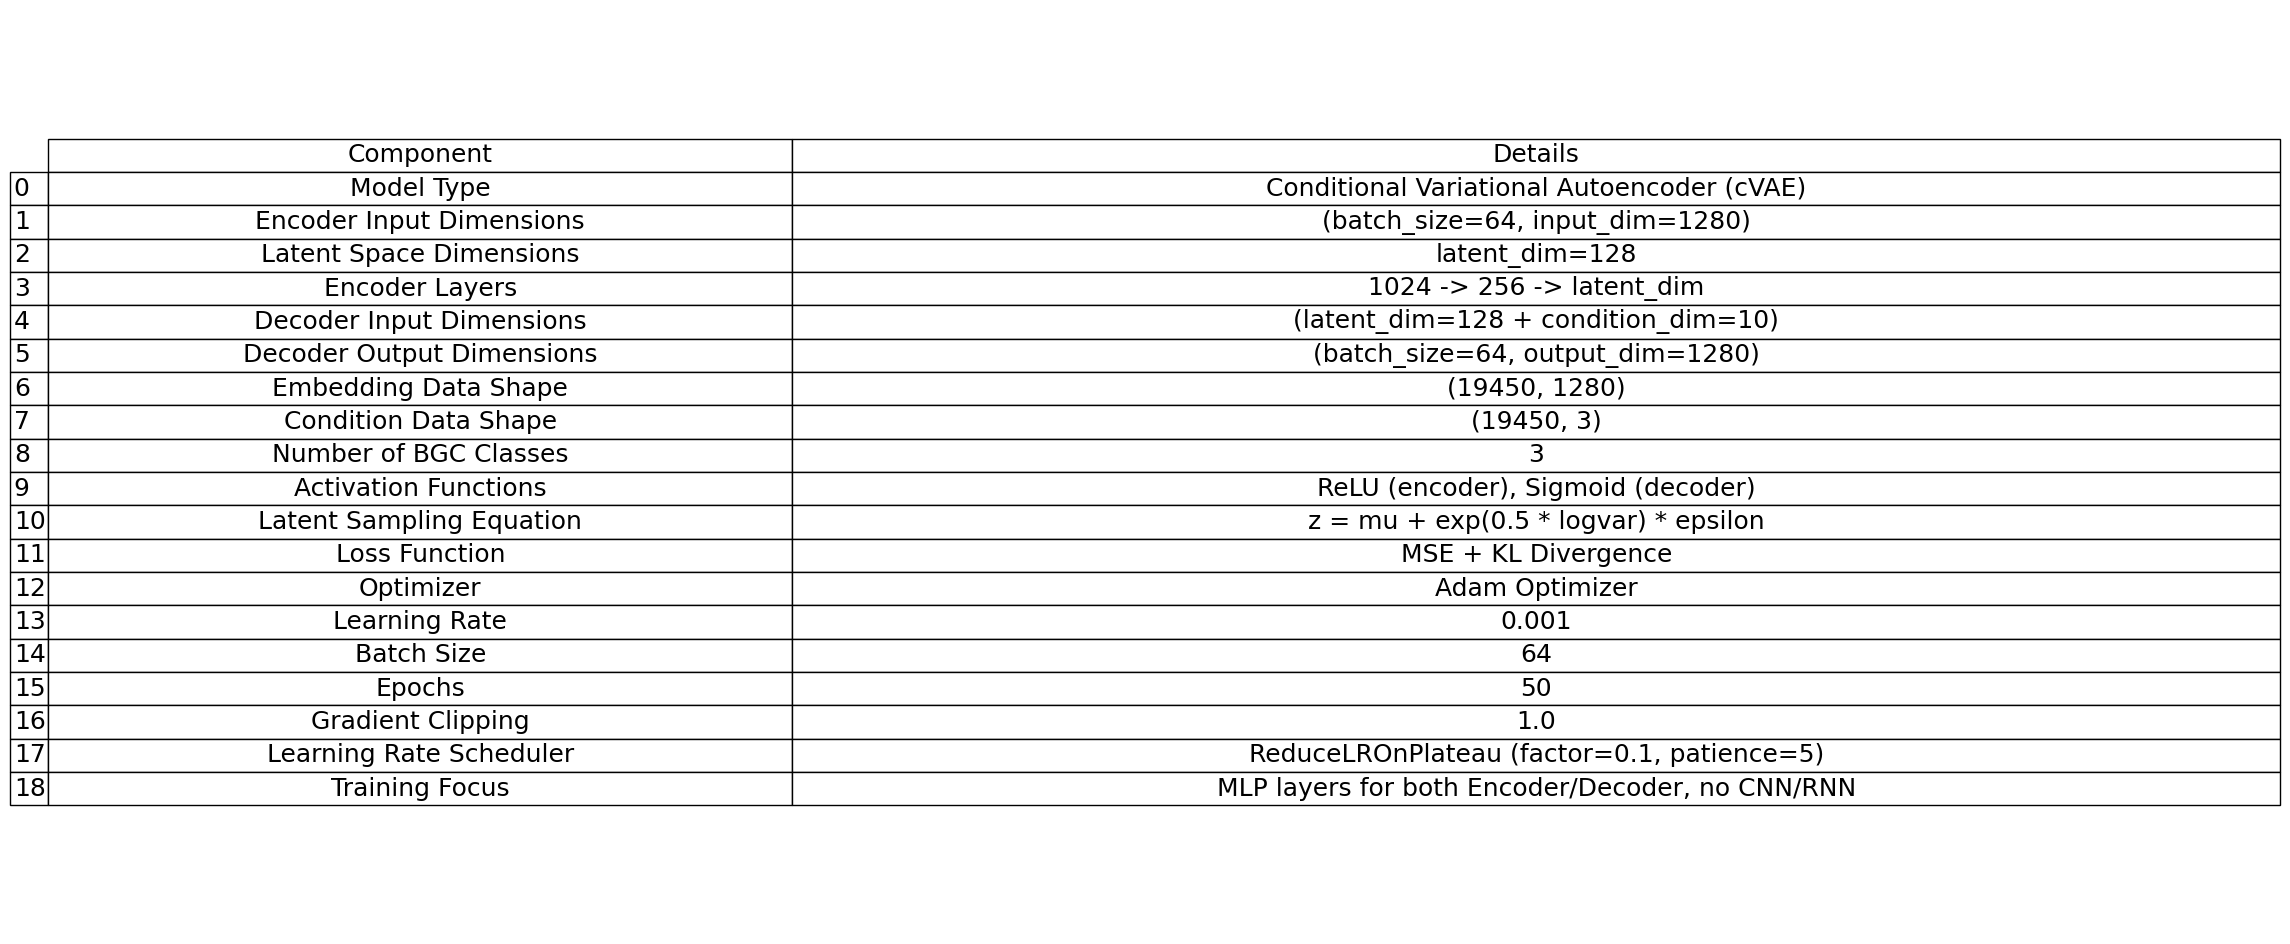

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

# Define the model details with sizes, dimensions, and specifications
data = {
    "Component": [
        "Model Type", 
        "Encoder Input Dimensions", 
        "Latent Space Dimensions", 
        "Encoder Layers", 
        "Decoder Input Dimensions", 
        "Decoder Output Dimensions", 
        "Embedding Data Shape", 
        "Condition Data Shape", 
        "Number of BGC Classes", 
        "Activation Functions", 
        "Latent Sampling Equation", 
        "Loss Function", 
        "Optimizer", 
        "Learning Rate", 
        "Batch Size", 
        "Epochs", 
        "Gradient Clipping", 
        "Learning Rate Scheduler",  # Added Learning Rate Scheduler
        "Training Focus"
    ],
    "Details": [
        "Conditional Variational Autoencoder (cVAE)", 
        "(batch_size=64, input_dim=1280)", 
        "latent_dim=128", 
        "1024 -> 256 -> latent_dim", 
        "(latent_dim=128 + condition_dim=10)", 
        "(batch_size=64, output_dim=1280)", 
        "(19450, 1280)", 
        "(19450, 3)", 
        "3", 
        "ReLU (encoder), Sigmoid (decoder)", 
        "z = mu + exp(0.5 * logvar) * epsilon", 
        "MSE + KL Divergence", 
        "Adam Optimizer", 
        "0.001", 
        "64", 
        "50", 
        "1.0", 
        "ReduceLROnPlateau (factor=0.1, patience=5)", 
        "MLP layers for both Encoder/Decoder, no CNN/RNN"
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create a plot to save the table as an image
fig, ax = plt.subplots(figsize=(16, 12))  # Set figure size
ax.axis('tight')
ax.axis('off')

# Create the table
table_plot = table(ax, df, loc='center', cellLoc='center', colWidths=[0.3, 0.6])

# Customize the appearance
table_plot.auto_set_font_size(False)
table_plot.set_fontsize(18)  # Increased font size
table_plot.scale(2.0, 2.0)  # Adjusted scaling for better readability

# Save the table as an image
plt.savefig("model_architecture_summary_with_lr_scheduler.jpg", dpi=300, bbox_inches="tight")
plt.show()


### Evaluating the Training Loss

Plotting the training loss over epochs to understand how well the model converged.

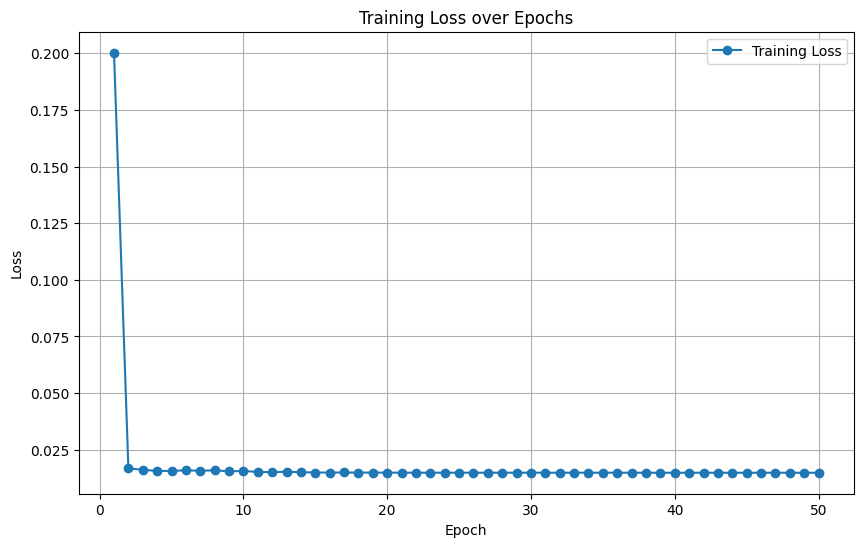

In [16]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label="Training Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.savefig("training_loss_plot.png", dpi=300, bbox_inches="tight")
plt.show()


### Visualizing the Latent Space

To evaluate the latent representations, we will:

1. Encode the input embeddings using the encoder.
2. Reduce the latent space to 2D using dimensionality reduction techniques, t-SNE.
3. Visualize the points, optionally color-coded by their conditions (BGC class).

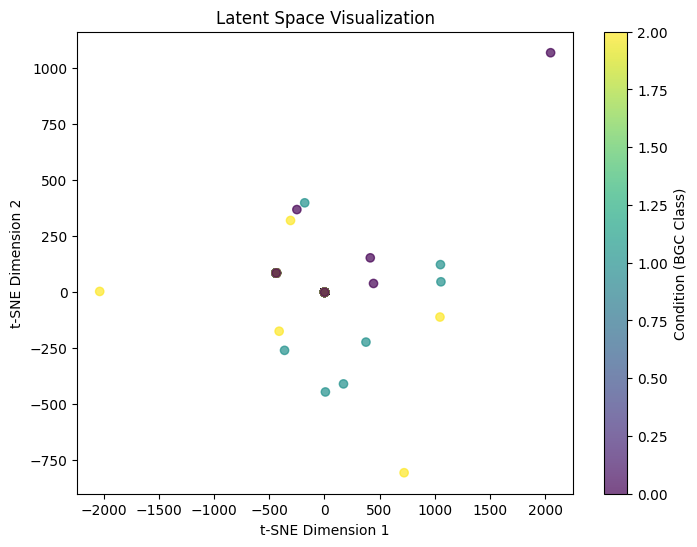

In [26]:
# Pass embeddings through the encoder
vae.eval()
with torch.no_grad():
    latent_vectors = []
    for i in range(embedding_data.shape[0]):
        embedding = embedding_data[i].unsqueeze(0)  # Add batch dimension
        condition = condition_data[i].unsqueeze(0)  # Add batch dimension
        mean, _ = vae.encoder(embedding, condition)
        latent_vectors.append(mean.numpy().flatten())

latent_vectors = np.array(latent_vectors)

# Use t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

# Plot the reduced latent space
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=np.argmax(condition_data.numpy(), axis=1), cmap='viridis', alpha=0.7)
plt.colorbar(label="Condition (BGC Class)")
plt.title("Latent Space Visualization")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.savefig("latent_space_visualization.png", dpi=300, bbox_inches="tight")  # Save the plot
plt.show()


In [ ]:
### Computing the FID Score

The FID score is calculated as:

$$
FID = ||\mu_1 - \mu_2||^2 + \text{Tr}(C_1 + C_2 - 2 \sqrt{C_1 C_2})
$$

Where:

- **$\mu_1$**: Mean of the real embeddings (feature distribution of real data).
- **$\mu_2$**: Mean of the generated embeddings (feature distribution of generated data).
- **$C_1$**: Covariance matrix of the real embeddings.
- **$C_2$**: Covariance matrix of the generated embeddings.
- **$\text{Tr}$**: Trace of a matrix (sum of its diagonal elements).
- **$||\mu_1 - \mu_2||^2$**: Squared Euclidean distance between the means of the real and generated embeddings.
- **$\sqrt{C_1 C_2}$**: Matrix square root of the product of the covariance matrices.


### Reconstructing Inputs

Evaluate how well the decoder can reconstruct the input embeddings given the latent representations and conditions. We will measure reconstruction quality and visualize reconstructed embeddings.

In [21]:
# Select a few random samples to reconstruct
vae.eval()
samples = embedding_data[:5]  # Replace with random indices if needed
conditions = condition_data[:5]

# Perform reconstruction
with torch.no_grad():
    reconstructed, _, _ = vae(samples, conditions)

# Compare original and reconstructed embeddings
for i in range(samples.shape[0]):
    print(f"Sample {i + 1}")
    print("Original:", samples[i].numpy()[:10])  # Show first 10 features
    print("Reconstructed:", reconstructed[i].numpy()[:10])  # Show first 10 features
    print()


Sample 1
Original: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reconstructed: [0.00036682 0.00050767 0.00032589 0.00031136 0.00038933 0.00032864
 0.00054313 0.00033147 0.00044776 0.00041294]

Sample 2
Original: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reconstructed: [0.00033174 0.00046025 0.000479   0.00040998 0.00050965 0.00044127
 0.00032581 0.00054384 0.00049878 0.0003486 ]

Sample 3
Original: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reconstructed: [0.00041563 0.00039313 0.00039437 0.00032434 0.00033561 0.0003995
 0.00030061 0.000319   0.00035207 0.00029993]

Sample 4
Original: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reconstructed: [0.00029698 0.00027147 0.00027116 0.00034341 0.00038109 0.00035083
 0.00033154 0.00032419 0.00032309 0.00029841]

Sample 5
Original: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reconstructed: [0.00023766 0.00038564 0.00028033 0.00023177 0.00027359 0.00030086
 0.00033557 0.0003691  0.00036541 0.00029726]



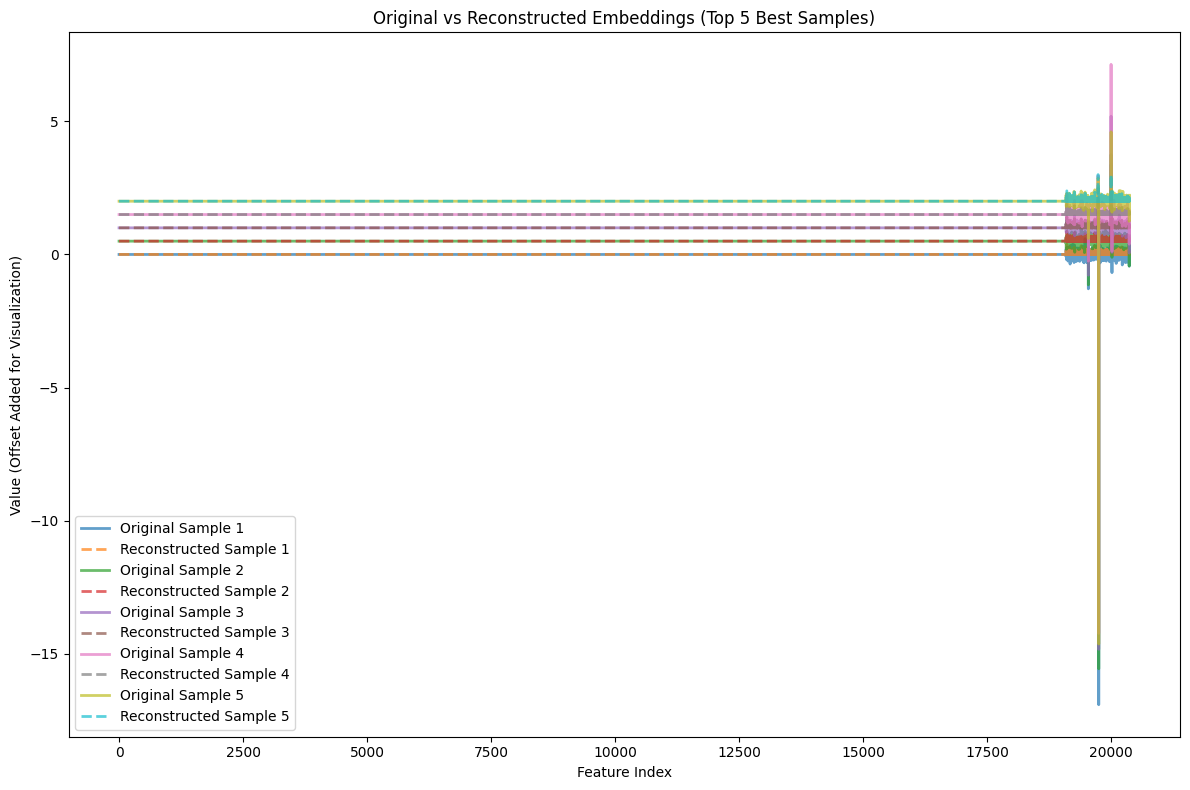

In [29]:
# Ensure the model is in evaluation mode
vae.eval()

# Select a few random samples to reconstruct
num_samples = 5  # Number of samples to visualize
sample_indices = torch.randint(0, embedding_data.shape[0], (num_samples,))  # Random indices
samples = embedding_data[sample_indices]
conditions = condition_data[sample_indices]

# Perform reconstruction
with torch.no_grad():
    reconstructed, _, _ = vae(samples, conditions)

# Plot original and reconstructed embeddings for all samples on a single graph
plt.figure(figsize=(12, 8))

for i in range(num_samples):
    offset = i * 0.5  # Offset for better visibility
    plt.plot(samples[i].numpy() + offset, label=f"Original Sample {i + 1}", alpha=0.7, linewidth=2)
    plt.plot(reconstructed[i].numpy() + offset, label=f"Reconstructed Sample {i + 1}", alpha=0.7, linewidth=2, linestyle="--")

# Add labels and legend
plt.title("Original vs Reconstructed Embeddings (Top 5 Best Samples)")
plt.xlabel("Feature Index")
plt.ylabel("Value (Offset Added for Visualization)")
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig("original_vs_reconstructed_single_graph.png", dpi=300, bbox_inches="tight")
plt.show()


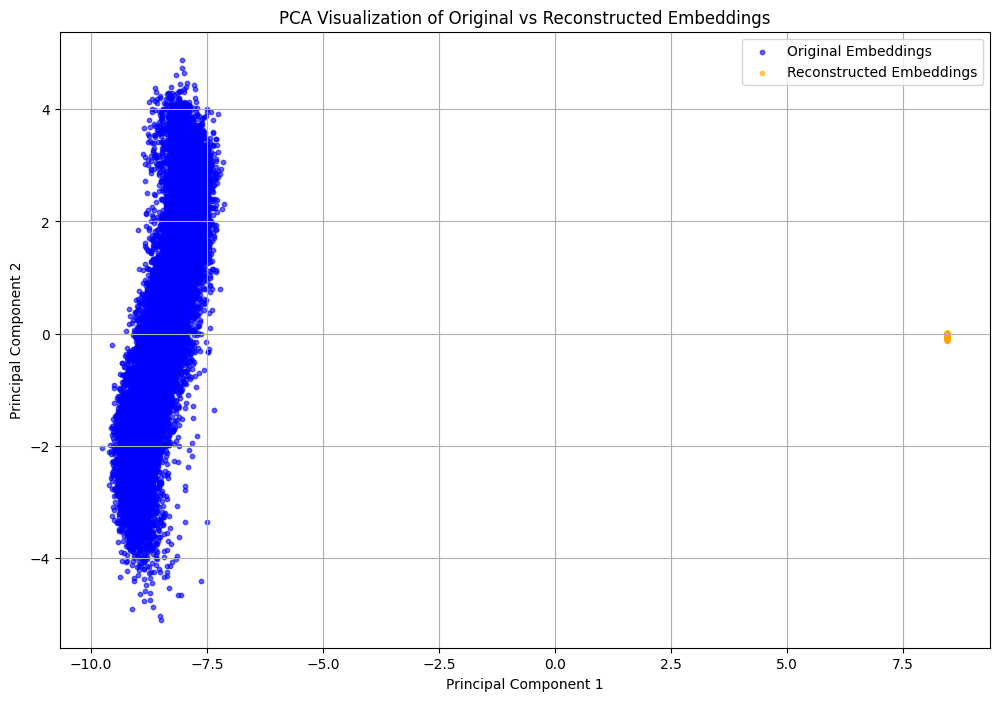

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
vae.eval()

# Perform reconstruction for all samples
with torch.no_grad():
    reconstructed, _, _ = vae(embedding_data, condition_data)

# Convert to NumPy arrays
original_embeddings = embedding_data.numpy()
reconstructed_embeddings = reconstructed.numpy()

# Apply PCA
pca = PCA(n_components=2)
pca.fit(np.vstack((original_embeddings, reconstructed_embeddings)))  # Fit PCA on both original and reconstructed
original_pca = pca.transform(original_embeddings)
reconstructed_pca = pca.transform(reconstructed_embeddings)

# Plot PCA results
plt.figure(figsize=(12, 8))

# Plot original embeddings
plt.scatter(original_pca[:, 0], original_pca[:, 1], alpha=0.6, label="Original Embeddings", c="blue", s=10)

# Plot reconstructed embeddings
plt.scatter(reconstructed_pca[:, 0], reconstructed_pca[:, 1], alpha=0.6, label="Reconstructed Embeddings", c="orange", s=10)

# Add labels, legend, and title
plt.title("PCA Visualization of Original vs Reconstructed Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()

# Save the plot
plt.savefig("pca_original_vs_reconstructed_full.png", dpi=300, bbox_inches="tight")
plt.show()


### Predict New Domain Configurations

To generate new domain configurations or embeddings, we will sample from the latent space and use the decoder.

Generate New Configurations:

1. Samples latent vectors from a Gaussian distribution (latent_samples).
2. Uses the decoder to generate new domain embeddings based on random conditions.

In [33]:
# Sample latent vectors from a Gaussian distribution
num_samples = 5
latent_samples = torch.randn((num_samples, latent_dim))

# Use the decoder with random conditions (e.g., one-hot encoded random BGC class)
random_conditions = condition_data[:num_samples]  # Replace with specific conditions if needed
generated = vae.decoder(latent_samples, random_conditions)

# Print or analyze generated embeddings
print("Generated Embeddings:")
print(generated)


Generated Embeddings:
tensor([[2.5863e-04, 4.2707e-04, 4.1404e-04,  ..., 9.6062e-06, 4.0119e-05,
         1.0753e-01],
        [2.5590e-04, 3.5858e-04, 3.6014e-04,  ..., 1.1590e-05, 2.4795e-05,
         1.0677e-01],
        [5.4918e-04, 4.2282e-04, 4.3060e-04,  ..., 1.5427e-05, 5.0193e-05,
         1.1427e-01],
        [2.7755e-04, 2.1385e-04, 2.1600e-04,  ..., 5.8367e-06, 3.2296e-05,
         1.0645e-01],
        [4.7741e-04, 4.7005e-04, 5.2525e-04,  ..., 2.3470e-05, 5.7748e-05,
         1.3089e-01]], grad_fn=<SigmoidBackward0>)


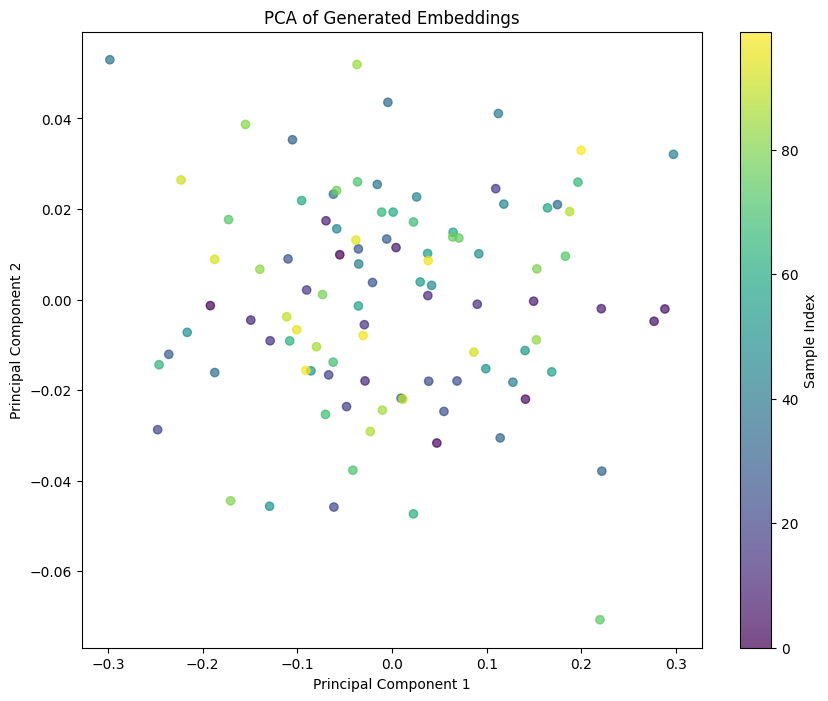

In [45]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
vae.eval()

# Number of new samples to generate
num_samples = 100  # Increase the number to make visualization more meaningful

# Sample latent vectors from a Gaussian distribution
latent_samples = torch.randn((num_samples, latent_dim))

# Use random conditions for generation
random_conditions = condition_data[:num_samples]  # Select conditions for visualization

# Generate new embeddings using the decoder
with torch.no_grad():
    generated_embeddings = vae.decoder(latent_samples, random_conditions)

# Combine generated embeddings into a single dataset for PCA
generated_embeddings_np = generated_embeddings.cpu().numpy()

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
generated_embeddings_2d = pca.fit_transform(generated_embeddings_np)

# Plot the reduced generated embeddings
plt.figure(figsize=(10, 8))
plt.scatter(
    generated_embeddings_2d[:, 0], 
    generated_embeddings_2d[:, 1], 
    c=range(num_samples), 
    cmap="viridis", 
    alpha=0.7
)
plt.colorbar(label="Sample Index")
plt.title("PCA of Generated Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Save the plot
plt.savefig("pca_generated_embeddings.png", dpi=300, bbox_inches="tight")
plt.show()


### Save Results

Saving the trained model, latent representations, or reconstructed outputs for further use or analysis.



In [37]:
# Save the trained model
torch.save(vae.state_dict(), "trained_cvae_model_50_epochs.pth")


In [38]:
# Save latent vectors and conditions for further analysis
np.save("latent_vectors.npy", latent_vectors)
np.save("latent_conditions.npy", condition_data.numpy())


### Evaluation with Fréchet Inception Distance (FID) Score

Fréchet Inception Distance (FID) is a metric for evaluating generative models like a cVAE, especially for assessing the quality of generated data (e.g., embeddings or domain configurations). The FID score compares the distributions of the real and generated data in a feature space, and lower FID scores indicate that the generated data is closer to the real data.

Why FID Score?

1. Reconstruction-Based Tasks: FID measures how similar the generated embeddings (or reconstructions) are to the real ones in terms of distribution.
2. Robustness: It captures not just pointwise similarity (like MSE) but also the overall quality and diversity of generated samples.
3. Widely Used: FID is commonly used in generative modeling tasks (e.g., GANs, VAEs) for evaluating the fidelity and diversity of generated data.


In [22]:
vae = cVAE(input_dim, condition_dim, latent_dim, output_dim)
vae.load_state_dict(torch.load("trained_cvae_model_50_epochs.pth"))
vae.eval()  # Set to evaluation mode

/var/folders/j3/hr2vkz5d6rsdcwsjr4bf6ydh0000gn/T/ipykernel_40349/959609490.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("trained_cvae_m

cVAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=20375, out_features=1024, bias=True)
    (fc2_mean): Linear(in_features=1024, out_features=256, bias=True)
    (fc2_logvar): Linear(in_features=1024, out_features=256, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=259, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=20372, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
)

In [39]:
print("Embedding Data Shape:", embedding_data.shape)
print("Condition Data Shape:", condition_data.shape)


Embedding Data Shape: torch.Size([19450, 20372])
Condition Data Shape: torch.Size([19450, 3])


#### Compute FID Score

Extracting Real and Generated Embeddings:
1. Pass real embeddings (from embedding_data) and generated embeddings (from the decoder) through a feature extractor (e.g., an Inception model).
2. Collect the activations (intermediate feature representations) for both sets of data.

In [40]:
# Generate reconstructions
vae.eval()
with torch.no_grad():
    reconstructed, _, _ = vae(embedding_data, condition_data)

# Use the original embeddings (real) and reconstructed embeddings (generated)
real_features = embedding_data.numpy()  # Real embeddings
generated_features = reconstructed.numpy()  # Generated embeddings


### Calculating the Mean and Covariance

Compute the mean and covariance for both the real and generated embeddings.


In [41]:
def calculate_statistics(features):
    """Calculate mean and covariance of the features."""
    mean = np.mean(features, axis=0)
    cov = np.cov(features, rowvar=False)
    return mean, cov

# Compute statistics for real and generated features
real_mean, real_cov = calculate_statistics(real_features)
gen_mean, gen_cov = calculate_statistics(generated_features)


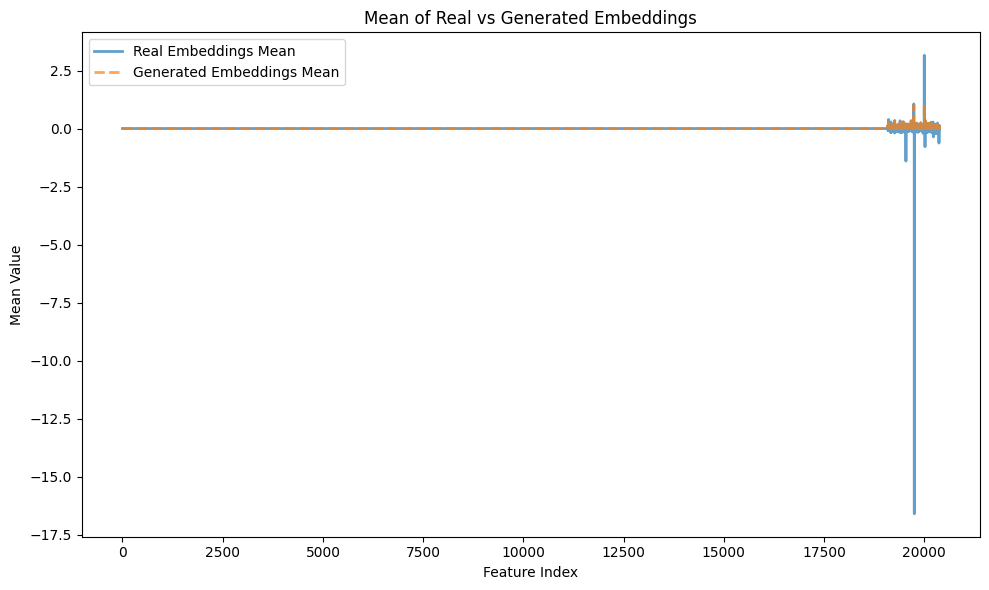

In [42]:
# Plot the means for comparison
plt.figure(figsize=(10, 6))
plt.plot(real_mean, label="Real Embeddings Mean", alpha=0.7, linewidth=2)
plt.plot(gen_mean, label="Generated Embeddings Mean", alpha=0.7, linewidth=2, linestyle="--")
plt.title("Mean of Real vs Generated Embeddings")
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.legend()
plt.tight_layout()
plt.show()

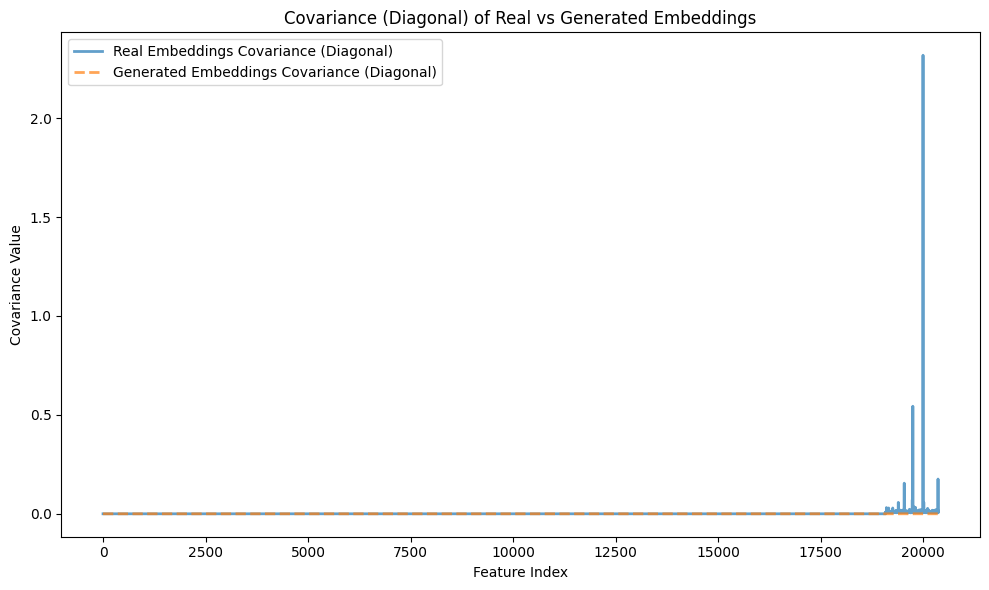

In [43]:
# Plot the diagonal of the covariance matrices for comparison
plt.figure(figsize=(10, 6))
plt.plot(np.diag(real_cov), label="Real Embeddings Covariance (Diagonal)", alpha=0.7, linewidth=2)
plt.plot(np.diag(gen_cov), label="Generated Embeddings Covariance (Diagonal)", alpha=0.7, linewidth=2, linestyle="--")
plt.title("Covariance (Diagonal) of Real vs Generated Embeddings")
plt.xlabel("Feature Index")
plt.ylabel("Covariance Value")
plt.legend()
plt.tight_layout()
plt.show()

### Computing the FID Score

The FID score is calculated as:

$$
FID = ||\mu_1 - \mu_2||^2 + \text{Tr}(C_1 + C_2 - 2 \sqrt{C_1 C_2})
$$

Where:

- **$\mu_1$**: Mean of the real embeddings (feature distribution of real data).
- **$\mu_2$**: Mean of the generated embeddings (feature distribution of generated data).
- **$C_1$**: Covariance matrix of the real embeddings.
- **$C_2$**: Covariance matrix of the generated embeddings.
- **$\text{Tr}$**: Trace of a matrix (sum of its diagonal elements).
- **$||\mu_1 - \mu_2||^2$**: Squared Euclidean distance between the means of the real and generated embeddings.
- **$\sqrt{C_1 C_2}$**: Matrix square root of the product of the covariance matrices.


In [ ]:
def calculate_statistics(features):
    """Calculate mean and covariance of the features."""
    mean = np.mean(features, axis=0)
    cov = np.cov(features, rowvar=False)
    return mean, cov

# Compute statistics for real and generated features
real_mean, real_cov = calculate_statistics(real_features)
gen_mean, gen_cov = calculate_statistics(generated_features)


In [ ]:
def calculate_statistics(features):
    """Calculate mean and covariance of the features."""
    mean = np.mean(features, axis=0)
    cov = np.cov(features, rowvar=False)
    return mean, cov

# Compute statistics for real and generated features
real_mean, real_cov = calculate_statistics(real_features)
gen_mean, gen_cov = calculate_statistics(generated_features)


In [ ]:
# Plot the means for comparison
plt.figure(figsize=(10, 6))
plt.plot(real_mean, label="Real Embeddings Mean", alpha=0.7, linewidth=2)
plt.plot(gen_mean, label="Generated Embeddings Mean", alpha=0.7, linewidth=2, linestyle="--")
plt.title("Mean of Real vs Generated Embeddings")
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Plot the diagonal of the covariance matrices for comparison
plt.figure(figsize=(10, 6))
plt.plot(np.diag(real_cov), label="Real Embeddings Covariance (Diagonal)", alpha=0.7, linewidth=2)
plt.plot(np.diag(gen_cov), label="Generated Embeddings Covariance (Diagonal)", alpha=0.7, linewidth=2, linestyle="--")
plt.title("Covariance (Diagonal) of Real vs Generated Embeddings")
plt.xlabel("Feature Index")
plt.ylabel("Covariance Value")
plt.legend()
plt.tight_layout()
plt.show()

### Interpret the FID Score
Lower is Better: A lower FID score means the generated embeddings are closer to the real ones.

Thresholds:

FID ~10: High-quality generations.

FID > 50: Poor-quality generations (distribution mismatch).

Advantages of FID over MSE

1. Captures Distributional Similarity: Unlike MSE, which evaluates individual points, FID compares entire distributions.
2. Handles Diversity: FID penalizes lack of diversity in generated data.
3. Task-Agnostic: FID works well for tasks where direct reconstruction is not the only goal (e.g., generating new domain configurations or embeddings).

### Time Complexity

#### How Much Time Will FID Calculation Take?

The time required to calculate the **Fréchet Inception Distance (FID)** using the provided function depends on several factors:

---

#### **Factors Influencing Time**
1. **Dimensionality of Features (Number of Features)**:
   - Higher-dimensional feature spaces (e.g., thousands of features) will take more time because matrix operations (like covariance computation and square root calculation) become more computationally expensive.

2. **Matrix Square Root (`sqrtm`)**:
   - This is the most computationally expensive operation in the function. It has a complexity of \(O(d^3)\), where \(d\) is the dimensionality of the covariance matrices.

3. **Hardware**:
   - The CPU or GPU you are using significantly impacts the computation time.

---

#### **Time Complexity**
Assuming \(d\) is the dimensionality of the embeddings (e.g., 2048 for Inception-based features):
- **Matrix Square Root (`sqrtm`)**: \(O(d^3)\)
- **Matrix Multiplication (`real_cov @ gen_cov`)**: \(O(d^3)\)
- **Trace Calculation and Mean Squared Error**: \(O(d^2)\)

Thus, the overall time complexity is approximately **\(O(d^3)\)**.

---

#### **Empirical Estimation**
- For embeddings of size \(d = 2048\), typical in Inception-based features:
  - **Small Datasets (e.g., 10,000 samples)**: A few seconds to a minute on a modern CPU.
  - **Larger Datasets**: Time increases proportionally with the number of samples due to covariance computation.

---

#### **Optimizing the Calculation**
1. **Use GPU Acceleration**:
   - Libraries like PyTorch or TensorFlow can handle matrix operations on GPUs more efficiently.

2. **Precompute Covariance**:
   - If you're comparing multiple generated sets to the same real data, precomputing the real data statistics (mean and covariance) can save time.

---

#### **Benchmarking FID Calculation**
You can measure the time taken to compute FID in your environment using Python’s `time` module:

```python
import time

start_time = time.time()
fid_score = calculate_fid(real_mean, real_cov, gen_mean, gen_cov)
end_time = time.time()

print(f"FID Score: {fid_score:.4f}")
print(f"Time Taken: {end_time - start_time:.4f} seconds")
